<a href="https://colab.research.google.com/github/carolsworld/DeepfakeDetector/blob/main/2_ModelM5_InceptionResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This is a notebook for training, validation and testing a binary classifier with InceptionResNet as the base model**

## Step 1 - Turn on GPU in runtime

In [ ]:
# Check GPU information 
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

## Step 2 - Dataset preprocessing

In [ ]:
# Mount to Google drive in case the connection is lost 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Pivot to relevant directory
%cd '/content/drive/MyDrive/DFD/data/MyDB/'

/content/drive/MyDrive/DFD/data/MyDB


In [ ]:
# Import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow

In [ ]:
# Set path 
base_dir = '/content/drive/MyDrive/DFD/data/MyDB'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Directory with our training fake faces
train_fake_dir = os.path.join(train_dir, 'Fake')

# Directory with our training real pictures
train_real_dir = os.path.join(train_dir, 'Real')

# Directory with our validation fake pictures
validation_fake_dir = os.path.join(validation_dir, 'Fake')

# Directory with our validation real pictures
validation_real_dir = os.path.join(validation_dir, 'Real')

# Directory with our test fake pictures
test_fake_dir = os.path.join(test_dir, 'Fake')

# Directory with our test real pictures
test_real_dir = os.path.join(test_dir, 'Real')

train_fake_fnames = os.listdir(train_fake_dir)
train_real_fnames = os.listdir(train_real_dir)

In [ ]:
# Print some file names to confirm the right directories are connected 
train_fake_fnames = os.listdir(train_fake_dir)
print(train_fake_fnames[:6])

train_real_fnames = os.listdir(train_real_dir)
train_real_fnames.sort()
print(train_real_fnames[:6])

['df03389.jpg', 'df03464.jpg', 'df03384.jpg', 'df03373.jpg', 'df03453.jpg', 'df03535.jpg']
['abarnvbtwb.mp40.jpgFace.jpg', 'abarnvbtwb.mp4120.jpgFace.jpg', 'abarnvbtwb.mp4144.jpgFace.jpg', 'abarnvbtwb.mp4168.jpgFace.jpg', 'abarnvbtwb.mp4192.jpgFace.jpg', 'abarnvbtwb.mp4216.jpgFace.jpg']


In [ ]:
# Count the number of real and fake images of faces in the train and validation directories
# Check against the figures in metadata file to confirm completeness

# For training, real images are 7,377 and fake images are 7,162.
print('total real images for training:', len(os.listdir(train_real_dir)))
print('total fake images for training:', len(os.listdir(train_fake_dir)))

# For validation, real images are 1,771 and fake images are 1,768.
print('total real images for validation:', len(os.listdir(validation_real_dir)))
print('total fake images for validation:', len(os.listdir(validation_fake_dir)))

total real images for training: 7377
total fake images for training: 7162
total real images for validation: 1771
total fake images for validation: 1768


## Step 3 - Data augmentation and normalisation

In [ ]:
BATCH_SIZE = 40
IMG_SIZE = (150, 150)

In [ ]:
train_dataset = tensorflow.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tensorflow.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

test_dataset = tensorflow.keras.utils.image_dataset_from_directory(test_dir,
                                                                 shuffle=False,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)


Found 14539 files belonging to 2 classes.
Found 3539 files belonging to 2 classes.
Found 200 files belonging to 2 classes.


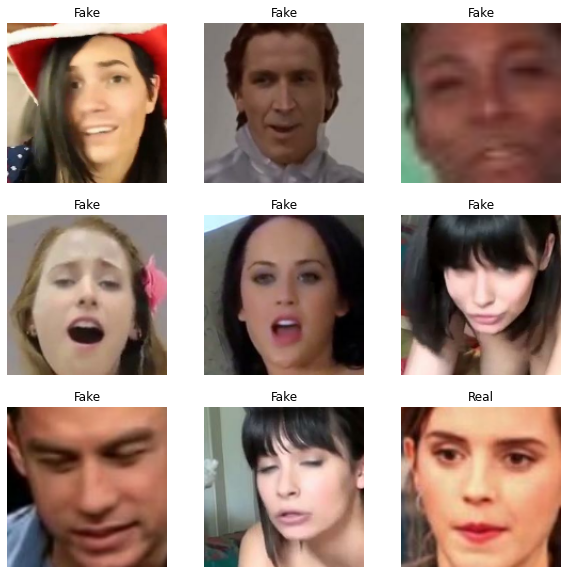

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [ ]:
AUTOTUNE = tensorflow.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tensorflow.keras.Sequential([
  tensorflow.keras.layers.RandomFlip('horizontal'),
  tensorflow.keras.layers.RandomRotation(0.2),
])

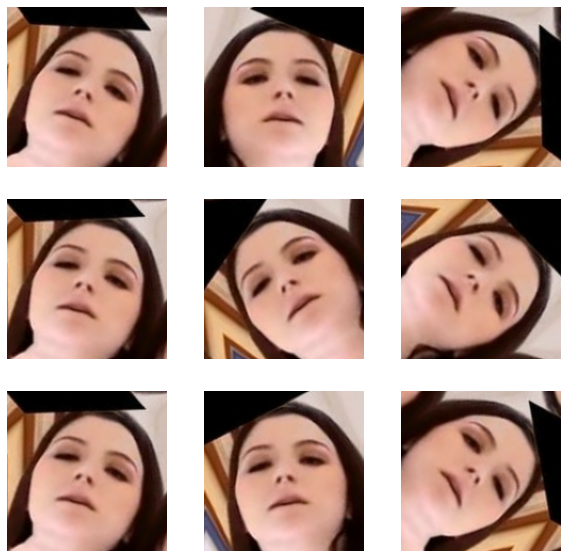

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tensorflow.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## Step 4 - Build the model

In [ ]:
preprocess_input = tensorflow.keras.applications.inception_resnet_v2.preprocess_input

In [ ]:
# Create the base model from the pre-trained model
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tensorflow.keras.applications.InceptionResNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

219070464/219055592 [==============================] - 2s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(40, 3, 3, 1536)


In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                

In [ ]:
global_average_layer = tensorflow.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(40, 1536)


In [ ]:
prediction_layer = tensorflow.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(40, 1)


In [ ]:
inputs = tensorflow.keras.Input(shape=(150, 150, 3))

x = data_augmentation(inputs)

x = preprocess_input(x)

x = base_model(x, training=False)

x = global_average_layer(x)

x = tensorflow.keras.layers.Dropout(0.2)(x)

outputs = prediction_layer(x)

model = tensorflow.keras.Model(inputs, outputs)

base_learning_rate = 0.0001

model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tensorflow.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 150, 150, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 150, 150, 3)      0         
 a)                                                              
                                                                 
 inception_resnet_v2 (Functi  (None, 3, 3, 1536)       54336736  
 onal)                                                           
                                                             

In [ ]:
len(model.trainable_variables)

2

## Step 5 - Train the model

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

89/89 [==============================] - 515s 5s/step - loss: 0.9471 - accuracy: 0.4936


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.95
initial accuracy: 0.49


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
364/364 [==============================] - 2109s 6s/step - loss: 0.7991 - accuracy: 0.5337 - val_loss: 0.6672 - val_accuracy: 0.6072
Epoch 2/10
364/364 [==============================] - 56s 151ms/step - loss: 0.7067 - accuracy: 0.5864 - val_loss: 0.6129 - val_accuracy: 0.6669
Epoch 3/10
364/364 [==============================] - 55s 151ms/step - loss: 0.6645 - accuracy: 0.6260 - val_loss: 0.5903 - val_accuracy: 0.6796
Epoch 4/10
364/364 [==============================] - 55s 149ms/step - loss: 0.6471 - accuracy: 0.6347 - val_loss: 0.5759 - val_accuracy: 0.6917
Epoch 5/10
364/364 [==============================] - 55s 151ms/step - loss: 0.6173 - accuracy: 0.6593 - val_loss: 0.5731 - val_accuracy: 0.7008
Epoch 6/10
364/364 [==============================] - 55s 150ms/step - loss: 0.6088 - accuracy: 0.6655 - val_loss: 0.5573 - val_accuracy: 0.7033
Epoch 7/10
364/364 [==============================] - 56s 152ms/step - loss: 0.5990 - accuracy: 0.6786 - val_loss: 0.5556 - val_acc

## Step 6 - Evaluate accuracy and loss for the model

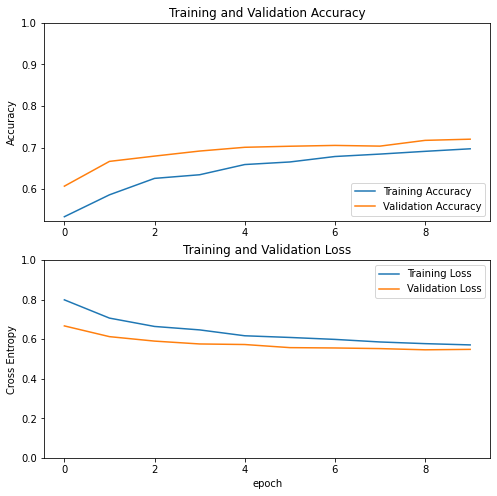

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Step 7 - Fine-tuning

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  780


In [ ]:
model.compile(loss=tensorflow.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tensorflow.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 150, 150, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 150, 150, 3)      0         
 a)                                                              
                                                                 
 inception_resnet_v2 (Functi  (None, 3, 3, 1536)       54336736  
 onal)                                                           
                                                             

In [ ]:
len(model.trainable_variables)

426

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
364/364 [==============================] - 141s 295ms/step - loss: 0.3369 - accuracy: 0.8411 - val_loss: 0.6002 - val_accuracy: 0.7810
Epoch 11/20
364/364 [==============================] - 104s 284ms/step - loss: 0.1782 - accuracy: 0.9215 - val_loss: 0.3853 - val_accuracy: 0.8531
Epoch 12/20
364/364 [==============================] - 105s 286ms/step - loss: 0.1243 - accuracy: 0.9494 - val_loss: 0.4796 - val_accuracy: 0.8375
Epoch 13/20
364/364 [==============================] - 105s 286ms/step - loss: 0.0929 - accuracy: 0.9614 - val_loss: 0.7163 - val_accuracy: 0.8132
Epoch 14/20
364/364 [==============================] - 104s 285ms/step - loss: 0.0773 - accuracy: 0.9678 - val_loss: 0.3804 - val_accuracy: 0.8836
Epoch 15/20
364/364 [==============================] - 104s 285ms/step - loss: 0.0649 - accuracy: 0.9736 - val_loss: 0.6777 - val_accuracy: 0.8519
Epoch 16/20
364/364 [==============================] - 105s 287ms/step - loss: 0.0553 - accuracy: 0.9781 - val_loss: 0

## Step 8 - Evaluate accuracy and loss for the fine-tuned model

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

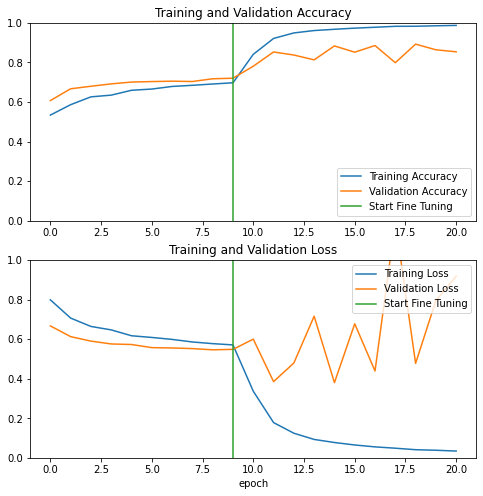

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Step 9 - Make prediction with unseen test dataset

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

5/5 [==============================] - 29s 6s/step - loss: 1.9864 - accuracy: 0.7350
Test accuracy : 0.7350000143051147


In [ ]:
# For testing of unseen images, there are 100 real images of faces and 100 fake images of faces.
base_dir = '/content/drive/MyDrive/DFD/data/MyDB'
test_dir = os.path.join(base_dir, 'test')

# Directory with our test fake pictures
test_fake_dir = os.path.join(test_dir, 'Fake')

# Directory with our test real pictures
test_real_dir = os.path.join(test_dir, 'Real')

print('total real images for test:', len(os.listdir(test_real_dir)))
print('total fake images for test:', len(os.listdir(test_fake_dir)))

total real images for test: 100
total fake images for test: 100


Predictions:
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0
 0 0 0]
Labels:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]


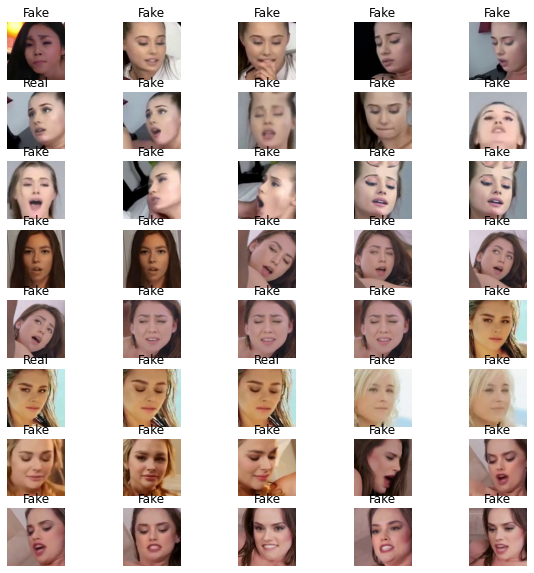

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tensorflow.nn.sigmoid(predictions)
predictions = tensorflow.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(40):
  ax = plt.subplot(8, 5, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [ ]:
# Upload the real faces to make prediction 
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/drive/MyDrive/DFD/data/MyDB/test/Real/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=1)
  if classes[0]>0.5:
    print(fn + " is real")
  else:
    print(fn + " is deepfake")

Saving 34_0.jpg to 34_0.jpg
Saving 34_6.jpg to 34_6.jpg
Saving 35_0.jpg to 35_0.jpg
Saving 39_360.jpg to 39_360.jpg
Saving 39_372.jpg to 39_372.jpg
Saving 39_384.jpg to 39_384.jpg
Saving 39_402.jpg to 39_402.jpg
Saving 39_780.jpg to 39_780.jpg
Saving 39_786.jpg to 39_786.jpg
Saving 40_0.jpg to 40_0.jpg
Saving 40_12.jpg to 40_12.jpg
Saving 40_24.jpg to 40_24.jpg
Saving 42_168.jpg to 42_168.jpg
Saving 42_198.jpg to 42_198.jpg
Saving 42_204.jpg to 42_204.jpg
Saving 43_36.jpg to 43_36.jpg
Saving 43_150.jpg to 43_150.jpg
Saving 43_192.jpg to 43_192.jpg
Saving 43_210.jpg to 43_210.jpg
Saving 44_6.jpg to 44_6.jpg
Saving 44_90.jpg to 44_90.jpg
Saving 44_192.jpg to 44_192.jpg
Saving 44_198.jpg to 44_198.jpg
Saving 45_60.jpg to 45_60.jpg
Saving 45_150.jpg to 45_150.jpg
Saving 46_360.jpg to 46_360.jpg
Saving 46_384.jpg to 46_384.jpg
Saving 47_528.jpg to 47_528.jpg
Saving 47_738.jpg to 47_738.jpg
Saving 48_12.jpg to 48_12.jpg
Saving 48_270.jpg to 48_270.jpg
Saving 48_318.jpg to 48_318.jpg
Saving 4

In [ ]:
# Upload the deepfake faces to make prediction 
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/drive/MyDrive/DFD/data/MyDB/test/Fake/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=1)
  if classes[0]>0.5:
    print(fn + " is real")
  else:
    print(fn + " is deepfake")

Saving 114_666.jpg to 114_666.jpg
Saving 115_306.jpg to 115_306.jpg
Saving 115_816.jpg to 115_816.jpg
Saving 116_24.jpg to 116_24.jpg
Saving 116_1056.jpg to 116_1056.jpg
Saving 117_12.jpg to 117_12.jpg
Saving 117_750.jpg to 117_750.jpg
Saving 118_9.jpg to 118_9.jpg
Saving 118_405.jpg to 118_405.jpg
Saving 119_65.jpg to 119_65.jpg
Saving 119_660.jpg to 119_660.jpg
Saving 120_50.jpg to 120_50.jpg
Saving 120_235.jpg to 120_235.jpg
Saving 121_24.jpg to 121_24.jpg
Saving 121_28.jpg to 121_28.jpg
Saving 122_0.jpg to 122_0.jpg
Saving 122_1.jpg to 122_1.jpg
Saving 124_154.jpg to 124_154.jpg
Saving 124_158.jpg to 124_158.jpg
Saving 124_160.jpg to 124_160.jpg
Saving 124_170.jpg to 124_170.jpg
Saving 125_65.jpg to 125_65.jpg
Saving 125_68.jpg to 125_68.jpg
Saving 125_69.jpg to 125_69.jpg
Saving 130_2.jpg to 130_2.jpg
Saving 130_34.jpg to 130_34.jpg
Saving 130_50.jpg to 130_50.jpg
Saving 130_78.jpg to 130_78.jpg
Saving 131_172.jpg to 131_172.jpg
Saving 131_212.jpg to 131_212.jpg
Saving 132_36.jpg 

## Step 10 - Determine the performance of the classifier

In [ ]:
# Figures for performance calculation
# real = 1, fake = 0
TP = true_pos = 50 # real faces predicted as real
TN = true_neg = 96 # fake faces predicted as fake
FP = false_pos = 4 # fake faces predicted as real
FN = false_neg = 50  # real faces predicted as fake

In [ ]:
results = {}

In [ ]:
# Accuracy
# Accuracy: the number of correctly predicted samples / total number of samples
metric = "ACC"
results[metric] = (TP + TN) / (TP + TN + FP + FN)
print(f"{metric} is {results[metric]: .3f}")

ACC is  0.730


In [ ]:
# True Positive Rate
# Recall / Sensitivity: the number of samples actually and predicted as Positive / total number of samples actually Positive
metric = "TPR"
results[metric] = TP / (TP + FN)
print(f"{metric} is {results[metric]: .3f}")

TPR is  0.500


In [ ]:
# True Negative Rate
# Specificity: the number of samples actually and predicted as Negative / total number of samples actually Negative
metric = "TNR"
results[metric] = TN / (TN + FP)
print(f"{metric} is {results[metric]: .3f}")

TNR is  0.960


In [ ]:
# Positive Predictive Value
# Precision: the number of samples actually and predicted as Positive / total number of samples predicted as Positive
metric = "PPV"
results[metric] = TP / (TP + FP)
print(f"{metric} is {results[metric]: .3f}")

PPV is  0.926


In [ ]:
# Negative Predictive Value
# The number of samples actually and predicted as Negative / total number of samples predicted as Negative
metric = "NPV"
results[metric] = TN / (TN + FN)
print(f"{metric} is {results[metric]: .3f}")

NPV is  0.658


In [ ]:
# F1 score
# Harmonic Mean of Precision and Recall
metric = "F1"
results[metric] = 2 / (1 / results["PPV"] + 1 / results["TPR"])
print(f"{metric} is {results[metric]: .3f}")

F1 is  0.649


In [ ]:
# Matthew's correlation coefficient
# Matthew's coefficient range between [-1, 1]. 0 usually means totally random predictions. 1 means a perfect classifier, while a negative value ([-1, 0)) suggests a negative correlation between predictions and actual values.
metric = "MCC"
num = TP * TN - FP * FN
den = ((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)) ** 0.5
results[metric] = num / den
print(f"{metric} is {results[metric]: .3f}")

MCC is  0.518


## Step 11 - Save model

In [ ]:
# Requirement to save the entire model (include architecture, weights, and training configuration in a single file/folder)
!pip install pyyaml h5py

In [ ]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save('my_InceptionResNetModel.h5')

In [ ]:
# Print a summary of model architecture
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 150, 150, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 150, 150, 3)      0         
 a)                                                              
                                                                 
 inception_resnet_v2 (Functi  (None, 3, 3, 1536)       54336736  
 onal)                                                           
                                                             

# End of Notebook